In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load and clean
df = pd.read_csv(r'C:\Users\15614\Documents\History_documents\combined_history_dataset.csv')
df = df.dropna(subset=["year", "region", "source", "text"])

# Split
train_df, eval_df = train_test_split(df, test_size=0.1, random_state=42)

# Write train set
with open("train.txt", "w", encoding="utf-8") as f:
    for _, row in train_df.iterrows():
        header = f"[YEAR: {row['year']}] [REGION: {row['region']}] [SOURCE: {row['source']}]"
        text = row['text'].strip().replace("\n", " ")
        f.write(f"{header}\n{text}\n\n")

# Write eval set
with open("eval.txt", "w", encoding="utf-8") as f:
    for _, row in eval_df.iterrows():
        header = f"[YEAR: {row['year']}] [REGION: {row['region']}] [SOURCE: {row['source']}]"
        text = row['text'].strip().replace("\n", " ")
        f.write(f"{header}\n{text}\n\n")


In [17]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from torch.utils.data import Dataset
import torch

# Load tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token  # <-- this line fixes the padding error

model = GPT2LMHeadModel.from_pretrained("distilgpt2")
model.resize_token_embeddings(len(tokenizer))

# Custom Dataset Class
class TextFileDataset(Dataset):
    def __init__(self, file_path, tokenizer, block_size=1024):
        with open(file_path, encoding="utf-8") as f:
            text = f.read()

        tokenized = tokenizer(text, return_tensors="pt", truncation=False)["input_ids"][0]

        # Break the long token stream into multiple blocks of size `block_size`
        self.examples = []
        for i in range(0, len(tokenized) - block_size + 1, block_size):
            block = tokenized[i:i+block_size]
            self.examples.append(block)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        return {"input_ids": self.examples[idx], "labels": self.examples[idx]}

# Prepare datasets
train_dataset = TextFileDataset("train.txt", tokenizer)
eval_dataset = TextFileDataset("eval.txt", tokenizer)

# Collator
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Training args (no evaluation strategy)
training_args = TrainingArguments(
    output_dir="./historical_model_output",
    overwrite_output_dir=True,
    num_train_epochs=8,
    per_device_train_batch_size=2,
    save_steps=500,
    logging_steps=100,
    save_total_limit=2,
    logging_dir="./logs",
    max_steps=1000
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator
)

# Train
trainer.train()

# Save
trainer.save_model("./historical_model_output")
tokenizer.save_pretrained("./historical_model_output")


Token indices sequence length is longer than the specified maximum sequence length for this model (8320178 > 1024). Running this sequence through the model will result in indexing errors
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
100,4.518000
200,4.284800
300,4.393100
400,4.330100
500,4.263600
600,4.319200
700,4.306400
800,4.387600
900,4.111300
1000,4.370300


c:\Users\15614\anaconda3\Lib\site-packages\transformers\utils\generic.py:271: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.array(obj)


('./historical_model_output\\tokenizer_config.json',
 './historical_model_output\\special_tokens_map.json',
 './historical_model_output\\vocab.json',
 './historical_model_output\\merges.txt',
 './historical_model_output\\added_tokens.json')

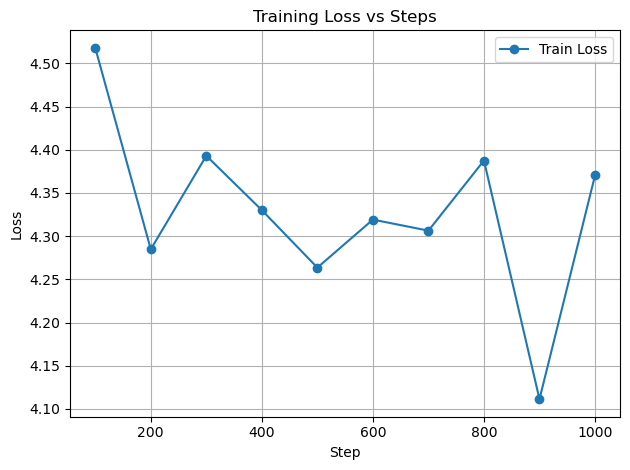

In [22]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history
steps = [entry["step"] for entry in log_history if "loss" in entry]
train_loss = [entry["loss"] for entry in log_history if "loss" in entry]
#eval_steps = [entry["step"] for entry in log_history if "eval_loss" in entry]
#eval_loss = [entry["eval_loss"] for entry in log_history if "eval_loss" in entry]

plt.plot(steps, train_loss, label="Train Loss", marker='o')
#plt.plot(eval_steps, eval_loss, label="Eval Loss", marker='x')
plt.title("Training Loss vs Steps")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
print(df["region"].unique())

['California' 'Texas' 'Florida' 'New York' 'Pennsylvania' 'Illinois'
 'Ohio' 'Georgia' 'North Carolina' 'Michigan' 'China' 'Greece' 'Rome'
 'Egypt' 'Africa' 'India' 'Oceania' 'Anatolia' 'Global' 'Mesopotamia'
 'Israel' 'Persia' 'England' 'Middle East' 'France' 'Asia' 'Germany'
 'Scotland' 'Italy' 'Turkey' 'Spain' 'Ireland' 'Europe' 'Americas'
 'Netherlands' 'Unknown']


In [25]:
import pandas as pd
import re
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch

# === Load dataset ===
df = pd.read_csv(r'C:\Users\15614\Documents\History_documents\combined_history_dataset.csv')
df = df.dropna(subset=["year", "region", "source", "text"])

# === Parse input year, allowing for BC ===
def parse_year(input_str):
    if "bc" in input_str.lower():
        digits = re.findall(r"\d+", input_str)
        return -int(digits[0]) if digits else None
    digits = re.findall(r"\d+", input_str)
    return int(digits[0]) if digits else None

# === Find closest prompt by year + region ===
def find_closest_prompt(df, input_year, input_region):
    try:
        input_year = int(input_year)
    except ValueError:
        return None

    region_matches = df[df["region"].str.lower().str.contains(input_region.lower())]

    if region_matches.empty:
        return None

    def year_distance(row):
        y = str(row["year"])
        match = re.match(r"(1[0-9]{3})[\–\-](1[0-9]{3})", y)
        if match:
            mid = (int(match.group(1)) + int(match.group(2))) // 2
        else:
            match = re.match(r"(1[0-9]{3})", y)
            if match:
                mid = int(match.group(1))
            else:
                return float("inf")
        return abs(mid - input_year)

    closest_row = region_matches.loc[region_matches.apply(year_distance, axis=1).idxmin()]
    return f"[YEAR: {closest_row['year']}] [REGION: {closest_row['region']}] [SOURCE: {closest_row['source']}]"

# === GPT-2 text generator ===
def generate_text(prompt, model_path="./historical_model_output", max_length=150):
    tokenizer = GPT2Tokenizer.from_pretrained(model_path)
    model = GPT2LMHeadModel.from_pretrained(model_path)

    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    attention_mask = torch.ones_like(input_ids)

    output = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=max_length,
        do_sample=True,
        temperature=0.9,
        top_k=50,
        top_p=0.95,
        num_return_sequences=1,
        pad_token_id=tokenizer.eos_token_id,
        repetition_penalty=1.3
    )

    return tokenizer.decode(output[0], skip_special_tokens=True)

# === Run interactive prompt ===
if __name__ == "__main__":
    try:
        input_year_raw = input(" Enter a year (e.g., 1400 or 500 BC): ").strip()
        input_region = input(" Enter a region (e.g., England): ").strip()

        input_year = parse_year(input_year_raw)
        if input_year is None:
            raise ValueError("Invalid year format.")

        selected_prompt = find_closest_prompt(df, input_year, input_region)

        if selected_prompt:
            print("\n Prompt:", selected_prompt)
            print("\n Generated Text:\n")
            print(generate_text(selected_prompt))
        else:
            print("\n No matching historical entries found.")
    except Exception as e:
        print(f"Error: {e}")






 Prompt: [YEAR: 1823] [REGION: France] [SOURCE: Project Gutenberg]

 Generated Text:

[YEAR: 1823] [REGION: France] [SOURCE: Project Gutenberg]
The Bible is one of the most well-known religious texts in Latin America, founded by a French missionary named T. Gage.[3]. By now it has been accepted as canonized for noncanonical purposes; but according to historian John O’Dale,[4], only about 578 copies exist on Wikipedia alone.[5][6](www). It was published after Spanish independence from Spain and subsequently under Pope Francis (1989). However many have since disappeared without further comment due some misconceptions regarding this text.[7]:13 So far, no other translations can be found online at http://bookshelves.org/en_wikipedia/.


In [26]:
import pandas as pd

# Load the combined CSV
df = pd.read_csv(r'C:\Users\15614\Documents\History_documents\combined_history_dataset.csv')

# Drop empty rows or broken entries
df = df.dropna(subset=["year", "region", "source", "text"]).reset_index(drop=True)

# Define split sizes
train_ratio = 0.8  # 80% train, 20% eval
split_index = int(len(df) * train_ratio)

df_train = df[:split_index]
df_eval = df[split_index:]

# Save train.txt
with open("train.txt", "w", encoding="utf-8") as f:
    for _, row in df_train.iterrows():
        header = f"[YEAR: {row['year']}] [REGION: {row['region']}] [SOURCE: {row['source']}]"
        text = row['text'].strip().replace("\n", " ")
        f.write(f"{header}\n{text}\n\n")

# Save eval.txt
with open("eval.txt", "w", encoding="utf-8") as f:
    for _, row in df_eval.iterrows():
        header = f"[YEAR: {row['year']}] [REGION: {row['region']}] [SOURCE: {row['source']}]"
        text = row['text'].strip().replace("\n", " ")
        f.write(f"{header}\n{text}\n\n")

print(f" Dataset split: {len(df_train)} train examples, {len(df_eval)} eval examples")

 Dataset split: 640 train examples, 160 eval examples


In [27]:
train_dataset = load_dataset("train.txt", tokenizer)
eval_dataset = load_dataset("eval.txt", tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator
)

c:\Users\15614\anaconda3\Lib\site-packages\transformers\data\datasets\language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [28]:
import math
results = trainer.evaluate()
print(f"Perplexity: {math.exp(results['eval_loss']):.2f}")

Perplexity: 38.42


In [29]:
with open("eval.txt", "r", encoding="utf-8") as f:
    raw_entries = f.read().strip().split("\n\n")

prompts = []
references = []

for entry in raw_entries:
    lines = entry.strip().split("\n")
    if len(lines) < 2:
        continue  # skip malformed blocks
    prompt = lines[0].strip()
    reference = lines[1].strip()
    prompts.append(prompt)
    references.append(reference)

# Create DataFrame and save
df_eval = pd.DataFrame({"prompt": prompts, "reference": references})
df_eval.to_csv("eval_for_metrics.csv", index=False, encoding="utf-8")

print(f"Saved {len(df_eval)} entries to eval_for_metrics.csv")

Saved 160 entries to eval_for_metrics.csv


In [38]:
import pandas as pd
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from bert_score import score as bert_score
from rouge_score import rouge_scorer

nltk.download("punkt")

# === Load model and tokenizer ===
model_path = "./historical_model_output"
tokenizer = GPT2Tokenizer.from_pretrained(model_path)
model = GPT2LMHeadModel.from_pretrained(model_path)
model.eval()

# === Load evaluation set ===
df = pd.read_csv("eval_for_metrics.csv").dropna(subset=["prompt", "reference"])

# === Generate text ===
def generate_text(prompt, max_length=150):
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    with torch.no_grad():
        output = model.generate(
            input_ids=input_ids,
            max_length=max_length,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=0.9,
            pad_token_id=tokenizer.eos_token_id,
            repetition_penalty=1.3
        )
    return tokenizer.decode(output[0], skip_special_tokens=True)

generated_texts = []
reference_texts = []

for _, row in df.iterrows():
    prompt = row["prompt"]
    reference = row["reference"]
    generated = generate_text(prompt)
    generated_texts.append(generated)
    reference_texts.append(reference)

# === BLEU ===
smooth_fn = SmoothingFunction().method4
bleu_scores = [
    sentence_bleu([nltk.word_tokenize(ref)], nltk.word_tokenize(gen), smoothing_function=smooth_fn)
    for ref, gen in zip(reference_texts, generated_texts)
]
average_bleu = sum(bleu_scores) / len(bleu_scores)

# === ROUGE (manual with rouge-score) ===
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = [scorer.score(ref, gen) for ref, gen in zip(reference_texts, generated_texts)]

avg_rouge1 = sum(score['rouge1'].fmeasure for score in rouge_scores) / len(rouge_scores)
avg_rouge2 = sum(score['rouge2'].fmeasure for score in rouge_scores) / len(rouge_scores)
avg_rougeL = sum(score['rougeL'].fmeasure for score in rouge_scores) / len(rouge_scores)

# === BERTScore ===
P, R, F1 = bert_score(generated_texts, reference_texts, lang="en")
average_bertscore_f1 = F1.mean().item()

# === Print results ===
print(f"\nAverage BLEU: {average_bleu:.4f}")
print(f"ROUGE-1 F1: {avg_rouge1:.4f}")
print(f"ROUGE-2 F1: {avg_rouge2:.4f}")
print(f"ROUGE-L F1: {avg_rougeL:.4f}")
print(f"BERTScore F1: {average_bertscore_f1:.4f}")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\15614\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

c:\Users\15614\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\15614\.cache\huggingface\hub\models--roberta-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Average BLEU: 0.0000
ROUGE-1 F1: 0.0170
ROUGE-2 F1: 0.0030
ROUGE-L F1: 0.0106
BERTScore F1: 0.7591


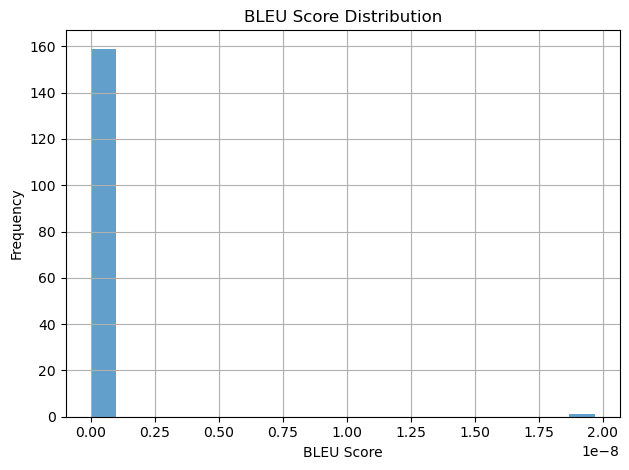

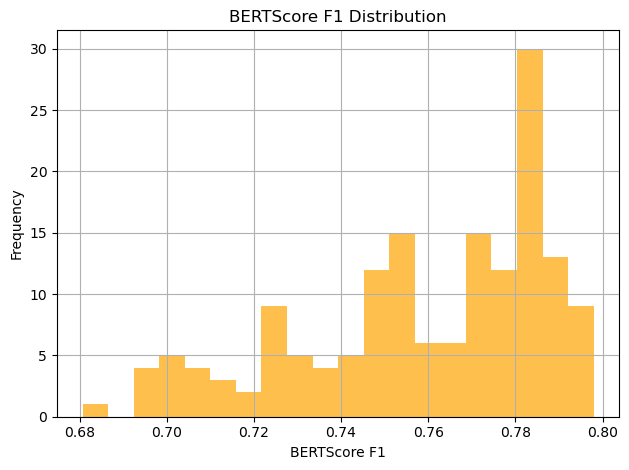

In [39]:
plt.hist(bleu_scores, bins=20, alpha=0.7)
plt.title("BLEU Score Distribution")
plt.xlabel("BLEU Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# BERTScore distribution
plt.hist(F1.numpy(), bins=20, alpha=0.7, color='orange')
plt.title("BERTScore F1 Distribution")
plt.xlabel("BERTScore F1")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()